### BiblioPal: Keep the Community Coming to Your Library. 

**Motivation**: Libraries are crucial to communities: they provide space, programs and resources free of charge at the time of use. In fact,  annually in the United States , there are 1.4 billion visits to libraries, 113 million program attendees and 2.2 billion materials are circulated each year. Therefore, libraries must (1) promote usage of their space and (2) understand how their operational choices impact library usage. 

I define library usage as Annual Visits/Local Population (or annual visits per person). Library usage varies significantly among public libraries (see data exploration below).

**Libraires make many choices that may impact usage**: 
1. Resource choice: Collections offered, programs offered, other services (bookmobile, interlibrary loans, hours open, etc.). 
2. Staffing choices: Number of librarians employed, education level of staff.
3. Spending choices: Collections spending, staff salaries and benefits. 

But which choices actually impact usage?

*BiblioPal is a tool to determine how libraries’ resources, staffing and spending choices affect library usage. It can be accessed here: ominkina.com*. 

**Business use case**: How can a library use BiblioPal?
Use case #1: Your library has increased funding next year (congratulations!). How can you best allocate those funds to efficiently increase library usage in your community?

Use case #2: Your library funding is limited next year. Where can you remove resources such that it has minimal impact on library usage?

**The data**:
The data used in this project is publicly available from the Institute of Museum and Library Services, which surveys over 9,000 public libraries in the United States annually.
I am using data from the last 7 years available (2010-2016), resulting in ~60,000 data points.

**Modeling strategy**: 
I used a random forest to predict library usage given operation (resource, spending, and staffing) choices. 

**End product**: BiblioPal is available at www.ominkina.com

In [2]:
#Load necessary packages
import pandas as pd
import os
import numpy as np
import copy
import pickle
import random

import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

from numpy.polynomial.polynomial import polyfit

### Data Prep
1. Load data (from Institute of Museum and Library services, 1992-2016) into dictionary of libraries labeled by year.
2. Rearrange columns in dataframe. 
3. Identify columns (features) present in each dataframe. 
4. Remove some features not useful for prediction 
5. Replace negative values with NaN (negative indicated NaN). 

In [3]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Load data
os.chdir("//Users/Olga/Documents/INSIGHT2019/Library data/AllPldData")
Files_in_folder = os.listdir()
File_names = ['_2014', '_2015', '_2016', '_2001', '_2002', '_2003', 
              '_2004','_2005', '_2006', '_2007', '_2008', '_2009', 
              '_2010', '_2011', '_2012', '_2013', '_2000', '_1992', 
              '_1993', '_1994', '_1995', '_1996', '_1997', '_1998', '_1999']
Files = []

for filename in os.listdir():
    if filename.endswith('csv'):
        Files.append(pd.read_csv(filename, encoding = 'latin-1', low_memory = False))
        
#create dictionary of libraries labeled by year
LibData_dict = {}
for i in range(0, len(File_names)):
    LibData_dict[File_names[i]] = Files[i]
    
for k, v in LibData_dict.items():
    print(k, v.shape, type(LibData_dict[k]))

ColumnsPresent = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibData_dict.items():
    dataframe_to_join = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent = ColumnsPresent.join(dataframe_to_join, how = 'outer')

#Rearrange columns in dataframe. 
cols = ColumnsPresent.columns.tolist()
cols_rearr = cols[17:] + cols[0:17]
cols_rearr2 = cols_rearr[0:8] + cols_rearr[24:25] + cols_rearr[11:24] + cols_rearr[8:11]

ColumnsPresent_rearr = ColumnsPresent[cols_rearr2]

ColumnsPresent_rearr_str = ColumnsPresent_rearr.applymap(str)
ColumnsPresent_rearr_str = ColumnsPresent_rearr_str.reset_index(drop = True)

#create DF of unique column values
UniqueLabels = np.unique(ColumnsPresent_rearr_str.values)
LabelsBoolDF = pd.DataFrame(UniqueLabels)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_rearr_str.columns)):
    lis = []
    for i in range(len(UniqueLabels)):
        lis.append(ColumnsPresent_rearr_str.iloc[:, j].isin([UniqueLabels[i]]).any())
    LabelsBoolDF[ColumnsPresent_rearr_str.columns[j]] = lis
    
## Sum all TRUE values. Value of 25 = all true
sum_list = []
for i in range(LabelsBoolDF.shape[0]):
    sum_list.append(sum(LabelsBoolDF.iloc[i, 1:26]))

#Label OK in Notes
LabelsBoolDF['TRUE SUM'] = sum_list
LabelsBoolDF['Notes'] = ""
LabelsBoolDF.loc[LabelsBoolDF[LabelsBoolDF['TRUE SUM']==25].index, 'Notes'] = "OK"

#rows in which not all TRUE (meaning this column/data does not exist for all year)
MissingData = LabelsBoolDF[LabelsBoolDF['TRUE SUM']!=25].index.tolist()

#Column names to keep
#LabelsBoolDF.loc[[0, 3:13, 15], 0].tolist()
Cols_to_keep_idx = [0]
Cols_to_keep_idx.extend(range(3,13))
Cols_to_keep_idx.extend((16, 18, 20, 25, 26))
Cols_to_keep_idx.extend(range(33, 49))
Cols_to_keep_idx.extend((64, 135, 137, 138, 183))
Cols_to_keep_idx.extend(range(185, 189))
Cols_to_keep_idx.extend(range(191, 199))
Cols_to_keep_idx.append(201)
Cols_to_keep_idx.extend(range(206, 219))
Cols_to_keep_idx.append(220)
Cols_to_keep_idx.extend(range(222, 229))
Cols_to_keep_idx.extend((230, 231, 237))
Cols_to_keep_idx.extend(range(237, 256))
Cols_to_keep_idx.extend(range(257, 260))
Cols_to_keep_idx.extend((262, 263))

Cols_to_keep_in_lib_dfs = LabelsBoolDF.iloc[Cols_to_keep_idx, 0].tolist()

#Make dictionaries of smaller dataframe with Cols_to_keep_in_lib_dfs ONLY
LibData_dict_reduced = dict()

for k, v in LibData_dict.items():
    LibData_dict_reduced[k] = pd.DataFrame()
    for i in Cols_to_keep_in_lib_dfs:
        if i in v:
            TempList = list(v[i])
            LibData_dict_reduced[k][i] = TempList

#Did above loop do what I thought it did?
print("Original dfs:")
for k, v in LibData_dict.items():
    print(k, v.shape)

print("\n", "Reduced dfs:")  
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

#Combine col names that mean same thing in different years into single 
Names_to_combine = ["ATTEND", "VISITS",  "C_LEGBAS", "C_LEGBASE", "DUPLI", "HRS_OPEN", "KIDATTEN", "KIDATTEND", 
                    "LIBRARIAN", "LIBRARIA", "POPU", "POPU_LSA", "POPU_UND", "POPU_UNDUP", "REFERENC", "REFERENCE", 
                    "STAFFEXP", "TOTEXP", "SUBSCRIP", "SUBSCRIPT", "TOTEXPCO", "TOTEXPCOL", 
                    "TOTOPEXP", "TOTOPEXP1", "TOTPEMP", "TOTSTAFF", "ZIP", "ZIP1"]

for i in range(0, len(Names_to_combine)-1, 2):
    for k, v in LibData_dict_reduced.items(): 
        if Names_to_combine[i] in v:
            name = Names_to_combine[i]
            newname = Names_to_combine[i] + "-" + Names_to_combine[i+1]
            v = v.rename(columns = {name: newname}, inplace = True)
        elif Names_to_combine[i+1] in v:
            name = Names_to_combine[i + 1]
            newname = Names_to_combine[i] + "-" + Names_to_combine[i+1]
            v = v.rename(columns = {name : newname}, inplace = True)

#Check that above code worked - names changes
for k, v in LibData_dict_reduced.items():
    print(v.columns)

for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

#Columns to add to DFs
"AUDIO is divided into AUDIO_PH, AUDIO_DL starting 2010. Source: 2010 Documentation."
"VIDEO was later split into VIDEO_DL and VIDEO_PH."

for k, v in LibData_dict_reduced.items(): 
    if "AUDIO_DL" in v:
        v["AUDIO"] = v['AUDIO_DL'] + v['AUDIO_PH']
    if "VIDEO_DL" in v:
        v["VIDEO"] = v['VIDEO_DL'] + v['VIDEO_PH']

#Check that # columns in some dataframes increased by 2 (expected)
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)
    
#Create DF w boolean values for prensence of each unique value in REDUCED dataframes
#THIS IS THE END GOAL OF THIS DATA

#Get all unique columns present in LibData_dict_reduced dataframes. 
ColumnsPresent_reduced = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibData_dict_reduced.items():
    dataframe_to_join_reduced = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent_reduced = ColumnsPresent_reduced.join(dataframe_to_join_reduced, how = 'outer')

ColumnsPresent_reduced_str = ColumnsPresent_reduced.applymap(str)
ColumnsPresent_reduced_str = ColumnsPresent_reduced_str.reset_index(drop = True)
    
UniqueLabels_reduced = np.unique(ColumnsPresent_reduced_str.values)
LabelsBoolDF_reduced = pd.DataFrame(UniqueLabels_reduced)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_reduced_str.columns)):
    lis = []
    for i in range(len(UniqueLabels_reduced)):
        lis.append(ColumnsPresent_reduced_str.iloc[:, j].isin([UniqueLabels_reduced[i]]).any())
    LabelsBoolDF_reduced[ColumnsPresent_reduced_str.columns[j]] = lis

## Sum all TRUE values. Value of 25 = all true
sum_list_reduced = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced.append(sum(LabelsBoolDF_reduced.iloc[i, 1:26]))

#Label OK in Notes
LabelsBoolDF_reduced['TRUE SUM'] = sum_list_reduced
LabelsBoolDF_reduced['Notes'] = ""
LabelsBoolDF_reduced.loc[LabelsBoolDF_reduced[LabelsBoolDF_reduced['TRUE SUM']==25].index, 'Notes'] = "OK"

All_Cols_in_Reduced_dfs = list(LabelsBoolDF_reduced[0])
All_Cols_in_Reduced_dfs

for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)
    
#Delete columns deemed NOT useful for downstream analysis
NonUsefulColstoDelete = ['ENDDATE', 'LIBID', 'PHONE', 'POPU_UND-POPU_UNDUP', 'RSTATUS', 'TOTCOLL', 'ZIP-ZIP1']

LibData_dict_reduced_dropuseless = copy.deepcopy(LibData_dict_reduced)

for k, v in LibData_dict_reduced_dropuseless.items(): 
    for i in range(len(NonUsefulColstoDelete)):
        if NonUsefulColstoDelete[i] in v:
            v.drop([NonUsefulColstoDelete[i]], axis = 1, inplace = True)
            
#Check quickly whether columns were dropped
print("Reduced dfs:")
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

print("\n", "Reduced and dropped useless dfs:")
for k, v in LibData_dict_reduced_dropuseless.items():    
    print(k, v.shape)

#Get rid of negative values (replace w NaN)
#For all DFs, replace (-1, -3, -9) values with NaN. 
LibData_dict_reduced_dropuseless_NegRepWNaN = copy.deepcopy(LibData_dict_reduced_dropuseless)

for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    v[(v == -1) | (v == -3) | (v == -9)] = np.nan
    
#See if this worked (looks like it did)
print(sum(LibData_dict_reduced_dropuseless['_2014']['AUDIO_DL'] < 0))
print(np.where((LibData_dict_reduced_dropuseless['_2014']['AUDIO_DL'] < 0) == True))

print(sum(LibData_dict_reduced_dropuseless_NegRepWNaN['_2014']['AUDIO_DL'].isnull()))
print(np.where(LibData_dict_reduced_dropuseless_NegRepWNaN['_2014']['AUDIO_DL'].isnull()))

for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    print(k, v.shape)
    


_2014 (9305, 159) <class 'pandas.core.frame.DataFrame'>
_2015 (9251, 159) <class 'pandas.core.frame.DataFrame'>
_2016 (9252, 151) <class 'pandas.core.frame.DataFrame'>
_2001 (9252, 151) <class 'pandas.core.frame.DataFrame'>
_2002 (9133, 108) <class 'pandas.core.frame.DataFrame'>
_2003 (9141, 107) <class 'pandas.core.frame.DataFrame'>
_2004 (9214, 110) <class 'pandas.core.frame.DataFrame'>
_2005 (9210, 128) <class 'pandas.core.frame.DataFrame'>
_2006 (9201, 131) <class 'pandas.core.frame.DataFrame'>
_2007 (9211, 139) <class 'pandas.core.frame.DataFrame'>
_2008 (9217, 148) <class 'pandas.core.frame.DataFrame'>
_2009 (9284, 150) <class 'pandas.core.frame.DataFrame'>
_2010 (9299, 152) <class 'pandas.core.frame.DataFrame'>
_2011 (9308, 154) <class 'pandas.core.frame.DataFrame'>
_2012 (9315, 157) <class 'pandas.core.frame.DataFrame'>
_2013 (9305, 155) <class 'pandas.core.frame.DataFrame'>
_2000 (9309, 157) <class 'pandas.core.frame.DataFrame'>
_1992 (9078, 108) <class 'pandas.core.frame.Data

_2014 (9305, 69)
_2015 (9251, 72)
_2016 (9252, 77)
_2001 (9252, 77)
_2002 (9133, 52)
_2003 (9141, 52)
_2004 (9214, 53)
_2005 (9210, 56)
_2006 (9201, 60)
_2007 (9211, 61)
_2008 (9217, 61)
_2009 (9284, 62)
_2010 (9299, 64)
_2011 (9308, 67)
_2012 (9315, 67)
_2013 (9305, 67)
_2000 (9309, 68)
_1992 (9078, 52)
_1993 (8944, 44)
_1994 (8929, 44)
_1995 (8920, 44)
_1996 (8981, 49)
_1997 (8946, 49)
_1998 (8968, 49)
_1999 (8966, 51)
Reduced dfs:
_2014 (9305, 69)
_2015 (9251, 72)
_2016 (9252, 77)
_2001 (9252, 77)
_2002 (9133, 52)
_2003 (9141, 52)
_2004 (9214, 53)
_2005 (9210, 56)
_2006 (9201, 60)
_2007 (9211, 61)
_2008 (9217, 61)
_2009 (9284, 62)
_2010 (9299, 64)
_2011 (9308, 67)
_2012 (9315, 67)
_2013 (9305, 67)
_2000 (9309, 68)
_1992 (9078, 52)
_1993 (8944, 44)
_1994 (8929, 44)
_1995 (8920, 44)
_1996 (8981, 49)
_1997 (8946, 49)
_1998 (8968, 49)
_1999 (8966, 51)

 Reduced and dropped useless dfs:
_2014 (9305, 63)
_2015 (9251, 66)
_2016 (9252, 70)
_2001 (9252, 70)
_2002 (9133, 47)
_2003 (9141, 47)


### Data Prep #2
1. Calculate usage for each library for all DFs. 
2. Delete libraries without usage data. 
3. Identify columns present in each dataframe, determine which dataframes to use to maximize features.
4. Make all dataframes consistent by adding all columns not present in specific dataframe with empty column (important for concatenation). 

In [5]:
#Add usage column to each library
for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    v['Usage'] = v['ATTEND-VISITS']/v['POPU-POPU_LSA']
    
#Check that column was added
for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    print(k, v.shape)
    
#Remove all rows (libraries) for which Usage data missing for any window!
LibwUsage = copy.deepcopy(LibData_dict_reduced_dropuseless_NegRepWNaN)
for k, v in LibwUsage.items():
    NullInd = v[v.Usage.isnull()].index
    print(k, v.shape)
    v = v.drop(NullInd, axis = 0)
    print(k, v.shape)

_2014 (9305, 64)
_2015 (9251, 67)
_2016 (9252, 71)
_2001 (9252, 71)
_2002 (9133, 48)
_2003 (9141, 48)
_2004 (9214, 49)
_2005 (9210, 51)
_2006 (9201, 55)
_2007 (9211, 56)
_2008 (9217, 56)
_2009 (9284, 57)
_2010 (9299, 59)
_2011 (9308, 62)
_2012 (9315, 62)
_2013 (9305, 62)
_2000 (9309, 63)
_1992 (9078, 48)
_1993 (8944, 40)
_1994 (8929, 40)
_1995 (8920, 40)
_1996 (8981, 45)
_1997 (8946, 45)
_1998 (8968, 45)
_1999 (8966, 47)
_2014 (9305, 64)
_2014 (9259, 64)
_2015 (9251, 67)
_2015 (9231, 67)
_2016 (9252, 71)
_2016 (9234, 71)
_2001 (9252, 71)
_2001 (9234, 71)
_2002 (9133, 48)
_2002 (9131, 48)
_2003 (9141, 48)
_2003 (9138, 48)
_2004 (9214, 49)
_2004 (9214, 49)
_2005 (9210, 51)
_2005 (9207, 51)
_2006 (9201, 55)
_2006 (9198, 55)
_2007 (9211, 56)
_2007 (9208, 56)
_2008 (9217, 56)
_2008 (9214, 56)
_2009 (9284, 57)
_2009 (9257, 57)
_2010 (9299, 59)
_2010 (9256, 59)
_2011 (9308, 62)
_2011 (9273, 62)
_2012 (9315, 62)
_2012 (9275, 62)
_2013 (9305, 62)
_2013 (9265, 62)
_2000 (9309, 63)
_2000 (9263, 6

In [6]:
#Get all unique columns present in LibData_dict_reduced dataframes. 
ColumnsPresent_reduced = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibwUsage .items():
    dataframe_to_join_reduced = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent_reduced = ColumnsPresent_reduced.join(dataframe_to_join_reduced, how = 'outer')
    
UniqueLabels_reduced = np.unique(ColumnsPresent_reduced_str.values)
LabelsBoolDF_reduced = pd.DataFrame(UniqueLabels_reduced)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_reduced_str.columns)):
    lis = []
    for i in range(len(UniqueLabels_reduced)):
        lis.append(ColumnsPresent_reduced_str.iloc[:, j].isin([UniqueLabels_reduced[i]]).any())
    LabelsBoolDF_reduced[ColumnsPresent_reduced_str.columns[j]] = lis
    
#Reorder columns
colnames = LabelsBoolDF_reduced.columns.tolist()
col_order = colnames[0:1] + colnames[18:26] + colnames[17:18] + colnames[4:17] + colnames[1:4]
LabelsBoolDF_reduced = LabelsBoolDF_reduced[col_order]

## Sum all TRUE values. Value of 25 = all true
sum_list_reduced_all = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_all.append(sum(LabelsBoolDF_reduced.iloc[i, 1:26]))
    
sum_list_reduced_ten = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_ten.append(sum(LabelsBoolDF_reduced.iloc[i, 15:26]))
    
sum_list_reduced_six = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_six.append(sum(LabelsBoolDF_reduced.iloc[i, 19:26]))

#Label OK in Notes
LabelsBoolDF_reduced['All_Years_Present'] = sum_list_reduced_all
LabelsBoolDF_reduced['2006_2016_Present'] = sum_list_reduced_ten
LabelsBoolDF_reduced['2010_2016_Present'] = sum_list_reduced_six

#Based on this, I will use 2010-2016 DF. This has the most values.
LabelsBoolDF_reduced.loc[29: ,:]

#Rename first column
LabelsBoolDF_reduced.rename(columns = {LabelsBoolDF_reduced.columns[0] : "Col"}, inplace = True)

In [7]:
#Make sure each df has all 83 columns. If column did not exist, add this column with NaN
Unique_col_names_list = list(LabelsBoolDF_reduced['Col'])

LibwUsage_2 = copy.deepcopy(LibwUsage)

for k, v in LibwUsage_2.items():
    for i in range(len(Unique_col_names_list)):
        if Unique_col_names_list[i] not in v:
            v[Unique_col_names_list[i]] = np.nan

for k, v in LibwUsage_2.items():
    print(k, v.shape)

_2014 (9305, 85)
_2015 (9251, 85)
_2016 (9252, 85)
_2001 (9252, 85)
_2002 (9133, 85)
_2003 (9141, 85)
_2004 (9214, 85)
_2005 (9210, 85)
_2006 (9201, 85)
_2007 (9211, 85)
_2008 (9217, 85)
_2009 (9284, 85)
_2010 (9299, 85)
_2011 (9308, 85)
_2012 (9315, 85)
_2013 (9305, 85)
_2000 (9309, 85)
_1992 (9078, 85)
_1993 (8944, 85)
_1994 (8929, 85)
_1995 (8920, 85)
_1996 (8981, 85)
_1997 (8946, 85)
_1998 (8968, 85)
_1999 (8966, 85)


### Data Prep #3
1. Concatenate DFs. 
2. Delete some non-useful columns.

In [16]:
#Concatenate 2010-2016
Concat201116 = pd.concat([LibwUsage_2['_2010'], LibwUsage_2['_2011'], LibwUsage_2['_2012'], LibwUsage_2['_2013'], LibwUsage_2['_2014'], LibwUsage_2['_2015'], LibwUsage_2['_2016']], axis=0, sort = False, join = "outer")
print(Concat201116.shape)

#rename first col
LabelsBoolDF_reduced.rename(columns = {LabelsBoolDF_reduced.columns[0] : "Col"}, inplace = True)

#Which features are not present in all 7 years?
Index = LabelsBoolDF_reduced[LabelsBoolDF_reduced['2010_2016_Present'] != 7].index

#Delete these features from DF.
Cols_to_delete = LabelsBoolDF_reduced.loc[Index, 'Col']
Cols_to_del_list = list(Cols_to_delete[:-1])
print("Columns to delete:", Cols_to_del_list)
Concat201116_INCOMPLETECOLSDEL = Concat201116.drop(columns = Cols_to_del_list)

print(Concat201116.shape)
print(Concat201116_INCOMPLETECOLSDEL.shape)

#Nonuseful columns to delete from above:
NonUsefulColstoDelete = ['ENDDATE', 'LIBID', 'PHONE', 'POPU_UND-POPU_UNDUP', 'RSTATUS', 'ZIP-ZIP1', 'nan']
Concat201116_INCOMPLETECOLSDEL2 = Concat201116_INCOMPLETECOLSDEL.drop(columns = NonUsefulColstoDelete)
print(Concat201116_INCOMPLETECOLSDEL2.shape)

Concat201116_INCOMPLETECOLSDEL2.columns

#Columns to move to front, not use 
'ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME',   

#Columns to delete prior to analysis
'GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'

#Put 'ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME' in dif DF
Location_Detail_DF = Concat201116_INCOMPLETECOLSDEL2[['ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'STABR', 'FSCSKEY', 'LIBNAME']]

#NOW delete from concatDF
Concat201116_INCOMPLETECOLSDEL3 = Concat201116_INCOMPLETECOLSDEL2.drop(columns = ['ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME'])

print(Concat201116_INCOMPLETECOLSDEL2.shape, Concat201116_INCOMPLETECOLSDEL3.shape)

#NOW HAVE 2 DFs:
#Concat201116_INCOMPLETECOLSDEL3
#Location_Detail_DF

## REMOVE ALL USAGE FEATURES (EXCEPT WHAT I AM TRYING TO PREDICT). 
#GET RID OF VIDEO_DL, VIDEO_PH for now too
ReducedDF = Concat201116_INCOMPLETECOLSDEL3.drop(columns = ['GPTERMS', 'KIDATTEN-KIDATTEND', 'KIDCIRCL', 'PITUSR', 'REGBOR', 'SUBSCRIP-SUBSCRIPT', 'TOTATTEN', 'TOTCIR', 'YAATTEN', 'REFERENC-REFERENCE', 'GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'])

#Leave 'Usage', 'POPU-POPU_LSA', so that I can divide!!

(65035, 85)
Columns to delete: ['AUDIO_DL', 'AUDIO_PH', 'EC_LO_OT', 'EC_ST', 'ELACCEXP', 'ELCONT', 'ELECCOLL', 'ELINFO', 'ELMATCIR', 'ELMATS', 'ELSVCACC', 'ERES_USR', 'ESUBSCRP', 'INETACC', 'PHYSCIR', 'REAPLOCALE', 'TOTCOLL', 'VIDEO_DL', 'VIDEO_PH', 'WIFISESS']
(65035, 85)
(65035, 65)
(65035, 58)
(65035, 58) (65035, 52)


### Data exploration
1. Library usage for all years (2010-2016).
2. NOTE: for more data exploration, please see previous notebooks. (i.e. usage changes over time in signle library, distibution of features, etc.)
3. NOTE: there is a bit more data exploration at the end of this notebook (correlation between features). 

Text(0,0.5,'Library frequency')

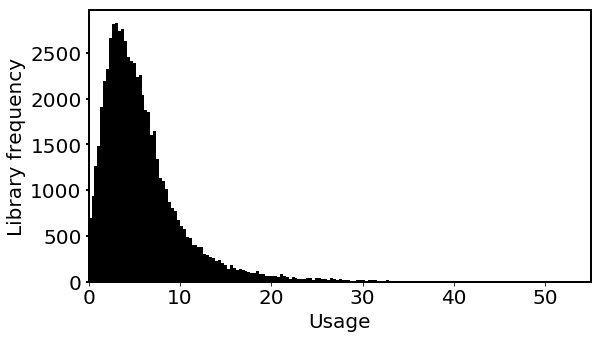

In [81]:
#Library usage for all years. 
#I am plotting only to usage of 55 (xlim = (0, 55)) because I removed outliers from RF below (outlier = usage over mean+5*SD) 
fig = plt.figure(figsize = (9,5))
plt.rcParams.update({'font.size': 20})
ax = fig.gca()
plt.xlabel("Usage")
plt.axvline(0, color='black', lw = 2)
plt.axhline(0, color='black', lw = 2)
plt.ylabel("y label")
ReducedDF['Usage'].plot.hist(grid = False, color = "black", bins = 5000, xlim = (0, 55))
ax.set_ylabel("Library frequency")

Text(0,0.5,'Library frequency')

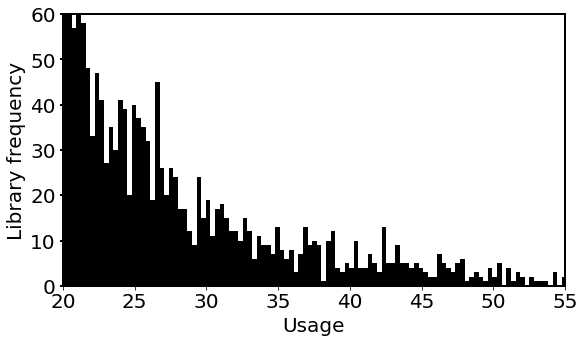

In [84]:
# Zoom to see higher usage 
fig = plt.figure(figsize = (9,5))
plt.rcParams.update({'font.size': 20})
ax = fig.gca()
plt.xlabel("Usage")
plt.axvline(0, color='black', lw = 2)
plt.axhline(0, color='black', lw = 2)
plt.ylabel("y label")
ReducedDF['Usage'].plot.hist(grid = False, color = "black", bins = 5000, xlim = (20, 55), ylim = (0, 60))
ax.set_ylabel("Library frequency")

### Prep Dataframe for Random Forest run:
1. Delete revenue information
2. Delete columns with spaces (OTHOPEXP', 'SALARIES', 'STAFFEXP-TOTEXP', 'BENEFIT')
3. Delete all library entries missing > 6 featur values. 
4. Impute all other missing values with column means.
5. Delete all rows where usage = 0
6. Delete usage outliers (mean + 5SD)
7. Ran RF 1 - poorly fits training set.
8. Divide all features except hours open by population served. 
9. Ran RF 2 - fit to training set is much better.

In [18]:
#Delete revenue columsn
Revenue_cols_to_delete  = ['CAP_REV','FCAP_REV','LOCGVT','OCAP_REV','OTHINCM','SCAP_REV','TOTINCM', 'STGVT']
ReducedDF_NoRev = ReducedDF.drop(columns = Revenue_cols_to_delete)

In [19]:
ReducedDF_NoRev.columns

Index(['AUDIO', 'BENEFIT', 'BKMOB', 'BKVOL', 'BRANLIB', 'CAPITAL', 'CENTLIB',
       'EBOOK', 'ELMATEXP', 'DUPLI-HRS_OPEN', 'KIDPRO', 'LIBRARIAN-LIBRARIA',
       'LOANFM', 'LOANTO', 'MASTER', 'OTHMATEX', 'OTHOPEXP', 'OTHPAID',
       'POPU-POPU_LSA', 'PRMATEXP', 'SALARIES', 'STAFFEXP-TOTEXP',
       'TOTEXPCO-TOTEXPCOL', 'TOTOPEXP-TOTOPEXP1', 'TOTPRO',
       'TOTPEMP-TOTSTAFF', 'VIDEO', 'YAPRO', 'Usage'],
      dtype='object')

In [20]:
#Delete columns with spaces.
#4 columns - 'OTHOPEXP', 'SALARIES', 'STAFFEXP-TOTEXP', 'BENEFIT' - are objects, meaning some balues are non-numeric
#It looks like some are left blank.
ReducedDF_NoRev = ReducedDF_NoRev.reset_index(drop=True)
Location_Detail_DF = Location_Detail_DF.reset_index(drop=True)

print(ReducedDF_NoRev[ReducedDF_NoRev.OTHOPEXP == ' '].index)
print(ReducedDF_NoRev[ReducedDF_NoRev.SALARIES == ' '].index)
print(ReducedDF_NoRev[ReducedDF_NoRev['STAFFEXP-TOTEXP'] == ' '].index)
print(ReducedDF_NoRev[ReducedDF_NoRev.BENEFIT == ' '].index)

#Are all indices the same? YES. 
print(len(ReducedDF_NoRev[ReducedDF_NoRev.OTHOPEXP == ' '].index.intersection(ReducedDF_NoRev[ReducedDF_NoRev.SALARIES == ' '].index)))
print(len(ReducedDF_NoRev[ReducedDF_NoRev.OTHOPEXP == ' '].index.intersection(ReducedDF_NoRev[ReducedDF_NoRev['STAFFEXP-TOTEXP'] == ' '].index)))
print(len(ReducedDF_NoRev[ReducedDF_NoRev.OTHOPEXP == ' '].index.intersection(ReducedDF_NoRev[ReducedDF_NoRev.BENEFIT == ' '].index)))

IndexToDropSpaces = ReducedDF_NoRev[ReducedDF_NoRev.OTHOPEXP == ' '].index

ReducedDF_NoRev_noSpace = ReducedDF_NoRev.drop(IndexToDropSpaces)
Location_Detail_DF_noSpace = Location_Detail_DF.drop(IndexToDropSpaces)
print(ReducedDF_NoRev.shape, Location_Detail_DF.shape)
print(ReducedDF_NoRev_noSpace.shape, Location_Detail_DF_noSpace.shape)

Int64Index([37227, 37229, 37232, 37233, 37234, 37235, 37237, 37238, 37240,
            37241,
            ...
            46477, 46478, 46480, 46489, 46491, 46492, 46493, 46500, 46506,
            46507],
           dtype='int64', length=3322)
Int64Index([37227, 37229, 37232, 37233, 37234, 37235, 37237, 37238, 37240,
            37241,
            ...
            46477, 46478, 46480, 46489, 46491, 46492, 46493, 46500, 46506,
            46507],
           dtype='int64', length=3322)
Int64Index([37227, 37229, 37232, 37233, 37234, 37235, 37237, 37238, 37240,
            37241,
            ...
            46477, 46478, 46480, 46489, 46491, 46492, 46493, 46500, 46506,
            46507],
           dtype='int64', length=3322)
Int64Index([37227, 37229, 37232, 37233, 37234, 37235, 37237, 37238, 37240,
            37241,
            ...
            46477, 46478, 46480, 46489, 46491, 46492, 46493, 46500, 46506,
            46507],
           dtype='int64', length=3322)
3322
3322
3322
(65035, 2

In [21]:
print(ReducedDF_NoRev_noSpace[ReducedDF_NoRev_noSpace.OTHOPEXP == ' '].index)

Int64Index([], dtype='int64')


In [22]:
ReducedDF_NoRev_noSpace['NaN total'] = ReducedDF_NoRev_noSpace.isnull().sum(axis=1)

In [23]:
#Delete all rows in which there are >6 NaN fields (20% of 30!)
ReducedDF_NoRev_noSpace = ReducedDF_NoRev_noSpace.reset_index(drop = True)
Location_Detail_DF_noSpace =Location_Detail_DF_noSpace.reset_index(drop = True)
Delete7NaNRows = ReducedDF_NoRev_noSpace[ReducedDF_NoRev_noSpace['NaN total'] > 6].index
ReducedDF_NoRev_noSpace_fewerNaN = ReducedDF_NoRev_noSpace.drop(Delete7NaNRows, axis = 0)
Location_Detail_DF_noSpace_fewerNaN = Location_Detail_DF_noSpace.drop(Delete7NaNRows, axis = 0)
print(ReducedDF_NoRev_noSpace.shape, ReducedDF_NoRev_noSpace_fewerNaN.shape)
print(Location_Detail_DF_noSpace.shape, Location_Detail_DF_noSpace_fewerNaN.shape)

(61713, 30) (61382, 30)
(61713, 7) (61382, 7)


In [24]:
#Convert all columns to floats.
ReducedDF_NoRev_noSpace_fewerNaN_float = ReducedDF_NoRev_noSpace_fewerNaN .astype('float')

In [25]:
#Fill missing values with column means
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled = ReducedDF_NoRev_noSpace_fewerNaN_float.fillna(ReducedDF_NoRev_noSpace_fewerNaN_float.mean())

In [26]:
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled['NaN total'] = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled.isnull().sum(axis=1)
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled['NaN total'].sum()

0

In [27]:
#Delete all rows where usage = 0 (there are very few libraries where this is true, so this is likely a mistake.)
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled.reset_index(drop = True)
Location_Detail_DF_noSpace_fewerNaN = Location_Detail_DF_noSpace_fewerNaN.reset_index(drop = True)

IdxUsage0 = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled[ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled.Usage == 0].index
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0 = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled.drop(IdxUsage0, axis = 0)
Location_Detail_DF_noSpace_fewerNaN_noUsage0 = Location_Detail_DF_noSpace_fewerNaN.drop(IdxUsage0, axis = 0)
#Check that it worked
print(ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0[ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.Usage == 0].index)
print(ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled.shape, ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.shape)
print(Location_Detail_DF_noSpace_fewerNaN.shape, Location_Detail_DF_noSpace_fewerNaN_noUsage0.shape)


Int64Index([], dtype='int64')
(61382, 30) (61343, 30)
(61382, 7) (61343, 7)


In [28]:
### Remove Outliers, defined as anything over mean+5*SD

ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0 = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.reset_index(drop = True)
Location_Detail_DF_noSpace_fewerNaN_noUsage0 = Location_Detail_DF_noSpace_fewerNaN_noUsage0.reset_index(drop = True)

mean_plus_5xSD = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.Usage.mean() + 5*ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.Usage.std()
OutlierIdx = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0[ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.Usage > mean_plus_5xSD].index
print("Number of outliers:", ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.loc[OutlierIdx, ['Usage']].shape[0])
      
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0_DropOutliers=ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.drop(OutlierIdx)
Location_Detail_DF_noSpace_fewerNaN_noUsage0_DropOutliers=Location_Detail_DF_noSpace_fewerNaN_noUsage0.drop(OutlierIdx)

print(ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.shape, ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0_DropOutliers.shape)
print(Location_Detail_DF_noSpace_fewerNaN_noUsage0.shape, Location_Detail_DF_noSpace_fewerNaN_noUsage0_DropOutliers.shape)


Number of outliers: 106
(61343, 30) (61237, 30)
(61343, 7) (61237, 7)


### Random forest #1. 
1. NOTE: This random forest does NOT perform well. This is because features are NOT normalized by population.

In [29]:
DFforRF1 = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0_DropOutliers.drop(columns = ['NaN total'])
LocforRF1 = Location_Detail_DF_noSpace_fewerNaN_noUsage0_DropOutliers
print(DFforRF1.shape, LocforRF1.shape)

(61237, 29) (61237, 7)


In [30]:
# Run first RF [Did not divide any values by population yet!!]
###GET random set of libraries to remove
DFforRF1 = DFforRF1.reset_index(drop=True)
LocforRF1 = LocforRF1.reset_index(drop=True)

UniqueFSCS = set(LocforRF1.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = LocforRF1[LocforRF1.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

9410
12244


                    importance
DUPLI-HRS_OPEN        0.086716
VIDEO                 0.076389
BKVOL                 0.069353
TOTPRO                0.058636
LOANFM                0.055089
OTHMATEX              0.050699
TOTOPEXP-TOTOPEXP1    0.049136
KIDPRO                0.046271
LOANTO                0.045371
OTHPAID               0.043426
AUDIO                 0.041668
TOTPEMP-TOTSTAFF      0.039366
PRMATEXP              0.039336
LIBRARIAN-LIBRARIA    0.036393
TOTEXPCO-TOTEXPCOL    0.034569
OTHOPEXP              0.029277
ELMATEXP              0.028740
YAPRO                 0.028095
BENEFIT               0.022178
MASTER                0.021549
EBOOK                 0.020875
SALARIES              0.020752
CAPITAL               0.020111
STAFFEXP-TOTEXP       0.017571
BRANLIB               0.013951
BKMOB                 0.003754
CENTLIB               0.000731


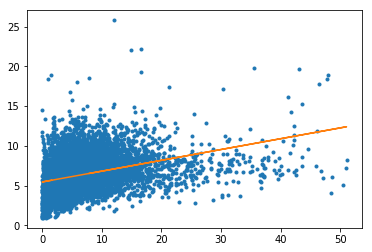

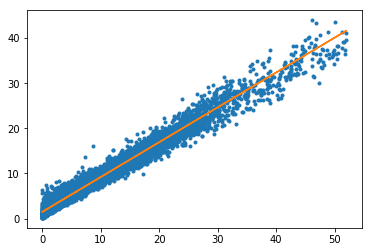

Score for Test set:  0.10884226036252498
Score for Train set:  0.929454621566564


In [31]:
#RF with SPECIFIC libraries removed.
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

X = DFforRF1.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = DFforRF1['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

### Random forest #2. 
1. Normalize features by population (where appropriate). 
2. Run random forest.
3. Try to reduce overfitting.

In [32]:
#Does dividing by POPU_LSA help? It should...
#divide all columns except for hours by population
DFforRF1_POPDIV = copy.deepcopy(DFforRF1)

cols_to_divide_by_pop = ['BENEFIT','BKMOB','BKVOL','BRANLIB','CAPITAL',
 'CENTLIB','EBOOK','ELMATEXP','KIDPRO',
 'LIBRARIAN-LIBRARIA',
 'LOANFM',
 'LOANTO',
 'MASTER',
 'OTHMATEX',
 'OTHOPEXP',
 'OTHPAID',
 'PRMATEXP',
 'SALARIES',
 'STAFFEXP-TOTEXP',
 'TOTEXPCO-TOTEXPCOL',
 'TOTOPEXP-TOTOPEXP1',
 'TOTPRO',
 'TOTPEMP-TOTSTAFF',
 'YAPRO',
 'AUDIO',
 'VIDEO']


for col in cols_to_divide_by_pop:
    DFforRF1_POPDIV[col] = DFforRF1_POPDIV[col].astype(float)/DFforRF1_POPDIV['POPU-POPU_LSA']

                    importance
TOTOPEXP-TOTOPEXP1    0.399147
TOTPEMP-TOTSTAFF      0.099300
TOTPRO                0.037460
DUPLI-HRS_OPEN        0.035948
LOANFM                0.034753
BKVOL                 0.033216
VIDEO                 0.030690
KIDPRO                0.030024
PRMATEXP              0.026424
AUDIO                 0.025564
TOTEXPCO-TOTEXPCOL    0.023253
CENTLIB               0.022208
LOANTO                0.021695
LIBRARIAN-LIBRARIA    0.021075
OTHMATEX              0.020287
OTHOPEXP              0.018232
OTHPAID               0.017464
YAPRO                 0.015803
BENEFIT               0.013726
ELMATEXP              0.013687
SALARIES              0.012763
EBOOK                 0.012376
MASTER                0.010982
STAFFEXP-TOTEXP       0.010488
CAPITAL               0.007792
BRANLIB               0.004320
BKMOB                 0.001324


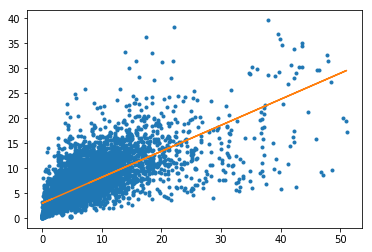

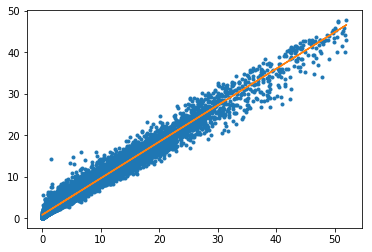

Score for Test set:  0.5075682736228992
Score for Train set:  0.9622668554129796


In [33]:
#RF with SPECIFIC libraries removed, and all values (except hours open) divided by PopuLSA!!.
#THIS WORKS MUCH MUCH BETTER
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

X = DFforRF1_POPDIV.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = DFforRF1_POPDIV['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

### RF above looks overfit:
1. I will not change number of trees (n_estimators) for now. In RF in Notebook 5, I saw no difference between 100 and 1000 trees (of course, the data there was processed very differently).
2. Try 0: Run as above for baseline
3. Try 1: Max features reduced to square root.
4. Try 2: Max depth reduced to 30 (from 60).
5. Try 3: Max features reduced to square root and depth reduced to 30 (from 60)
6. Try 4: Max features reduced to square root and depth reduced to 10

7. Conclusion: Changing above parameters did not significantly improve model (on test set). Try #4 decreased R^2 for train set (unsurprisinlgy given depth reduced severely), but did not improve R^2 for test set. 

In [34]:
#before trying all these diff options, I will make RF function.
def rffunction(DF_for_RF, n_est_number, rstate, mdepth, max_feat_str):
    rfmodel = RandomForestRegressor(n_estimators = n_est_number, random_state = rstate, max_depth = mdepth, max_features = max_feat_str)

    X = DF_for_RF.drop(columns = ['Usage', 'POPU-POPU_LSA'])
    y = DF_for_RF['Usage']

    X_train = X.drop(X.index[flattened_Indexlist])
    y_train = y.drop(y.index[flattened_Indexlist])
    X_test = X.loc[flattened_Indexlist]
    y_test = y.loc[flattened_Indexlist]

    #Train model on TRAIN set
    rfmodel.fit(X_train, y_train);

    #Test model on TEST set (this is the right this to do)
    predictions = rfmodel.predict(X_test)
    errors = abs(predictions - y_test)
    #df of predictions, labels and errors
    df_TEST = pd.DataFrame()
    df_TEST['Usage_val'] = y_test
    df_TEST['Predictions'] = predictions
    df_TEST['errors'] = (list(errors))

    #Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
    predictions = rfmodel.predict(X_train)
    errors = abs(predictions - y_train)
    #df of predictions, labels and errors
    df_TRAIN = pd.DataFrame()
    df_TRAIN['Usage_val'] = y_train
    df_TRAIN['Predictions'] = predictions
    df_TRAIN['errors'] = (list(errors))

    #Get feature importance
    feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                       index = X_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

    #Plot df_TEST Usage vs. Prediction:
    # Data
    x = df_TEST.iloc[:, 0]
    y = df_TEST.iloc[:, 1]
    # Fit with polyfit
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()

    #Plot df_TRAIN Usage vs. Prediction:
    # Data
    x = df_TRAIN.iloc[:, 0]
    y = df_TRAIN.iloc[:, 1]
    # Fit with polyfit
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()

    print("Score for Test set: ", rfmodel.score(X_test, y_test))
    print("Score for Train set: ", rfmodel.score(X_train, y_train))

Same as RF above.
                    importance
TOTOPEXP-TOTOPEXP1    0.399147
TOTPEMP-TOTSTAFF      0.099300
TOTPRO                0.037460
DUPLI-HRS_OPEN        0.035948
LOANFM                0.034753
BKVOL                 0.033216
VIDEO                 0.030690
KIDPRO                0.030024
PRMATEXP              0.026424
AUDIO                 0.025564
TOTEXPCO-TOTEXPCOL    0.023253
CENTLIB               0.022208
LOANTO                0.021695
LIBRARIAN-LIBRARIA    0.021075
OTHMATEX              0.020287
OTHOPEXP              0.018232
OTHPAID               0.017464
YAPRO                 0.015803
BENEFIT               0.013726
ELMATEXP              0.013687
SALARIES              0.012763
EBOOK                 0.012376
MASTER                0.010982
STAFFEXP-TOTEXP       0.010488
CAPITAL               0.007792
BRANLIB               0.004320
BKMOB                 0.001324


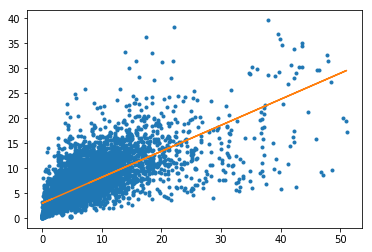

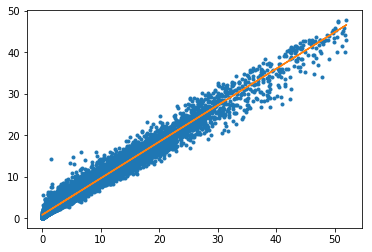

Score for Test set:  0.5075682736228992
Score for Train set:  0.9622668554129796
Max features reduced to square root
                    importance
TOTOPEXP-TOTOPEXP1    0.140805
TOTPEMP-TOTSTAFF      0.119839
TOTEXPCO-TOTEXPCOL    0.097058
PRMATEXP              0.053448
TOTPRO                0.050983
OTHPAID               0.049618
LIBRARIAN-LIBRARIA    0.039631
VIDEO                 0.039278
KIDPRO                0.036337
BKVOL                 0.034322
OTHMATEX              0.034198
DUPLI-HRS_OPEN        0.032745
AUDIO                 0.030735
LOANFM                0.030713
STAFFEXP-TOTEXP       0.024600
SALARIES              0.024471
CENTLIB               0.024244
LOANTO                0.023045
OTHOPEXP              0.022434
BENEFIT               0.020110
YAPRO                 0.016264
ELMATEXP              0.014879
MASTER                0.013387
EBOOK                 0.013105
CAPITAL               0.008605
BRANLIB               0.003858
BKMOB                 0.001287


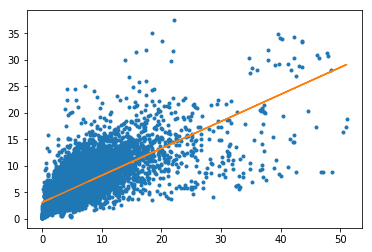

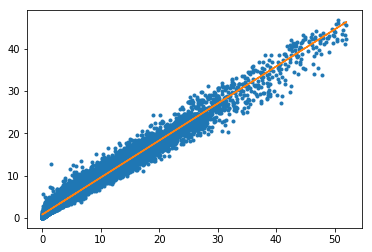

Score for Test set:  0.5173965878125613
Score for Train set:  0.9624315168977734
Max depth reduced to 30 (from 60)
                    importance
TOTOPEXP-TOTOPEXP1    0.399317
TOTPEMP-TOTSTAFF      0.099455
TOTPRO                0.037601
DUPLI-HRS_OPEN        0.036055
LOANFM                0.034721
BKVOL                 0.032986
VIDEO                 0.030626
KIDPRO                0.029970
PRMATEXP              0.026339
AUDIO                 0.025605
TOTEXPCO-TOTEXPCOL    0.023232
CENTLIB               0.022199
LOANTO                0.021744
LIBRARIAN-LIBRARIA    0.021197
OTHMATEX              0.020116
OTHOPEXP              0.018153
OTHPAID               0.017456
YAPRO                 0.015716
BENEFIT               0.013835
ELMATEXP              0.013614
SALARIES              0.012614
EBOOK                 0.012373
MASTER                0.010983
STAFFEXP-TOTEXP       0.010464
CAPITAL               0.007930
BRANLIB               0.004331
BKMOB                 0.001368


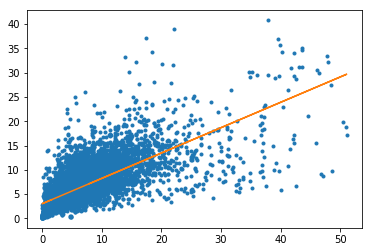

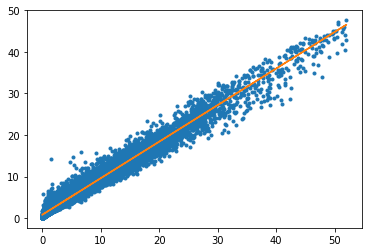

Score for Test set:  0.5084667058856489
Score for Train set:  0.9618178459858564
Max features reduced to square root and depth reduced to 30 (from 60)
                    importance
TOTOPEXP-TOTOPEXP1    0.142951
TOTPEMP-TOTSTAFF      0.120274
TOTEXPCO-TOTEXPCOL    0.091969
PRMATEXP              0.054760
TOTPRO                0.052509
OTHPAID               0.047377
VIDEO                 0.038956
OTHMATEX              0.037180
LIBRARIAN-LIBRARIA    0.036466
BKVOL                 0.035973
KIDPRO                0.035601
DUPLI-HRS_OPEN        0.032197
LOANFM                0.030997
AUDIO                 0.030933
STAFFEXP-TOTEXP       0.025770
CENTLIB               0.024733
SALARIES              0.024449
LOANTO                0.023703
OTHOPEXP              0.021929
BENEFIT               0.020069
YAPRO                 0.017016
ELMATEXP              0.014195
EBOOK                 0.013591
MASTER                0.012717
CAPITAL               0.008306
BRANLIB               0.004000
BKMOB       

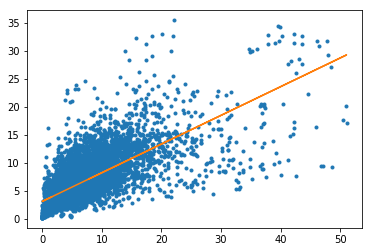

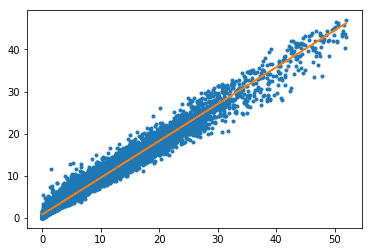

Score for Test set:  0.5158354603660971
Score for Train set:  0.9619257697668981


In [35]:
print("Same as RF above.")
rffunction(DF_for_RF = DFforRF1_POPDIV, n_est_number = 100, rstate = 42, mdepth = 60, max_feat_str = "auto")
print("Max features reduced to square root")
rffunction(DF_for_RF = DFforRF1_POPDIV, n_est_number = 100, rstate = 42, mdepth = 60, max_feat_str = "sqrt")
print("Max depth reduced to 30 (from 60)")
rffunction(DF_for_RF = DFforRF1_POPDIV, n_est_number = 100, rstate = 42, mdepth = 30, max_feat_str = "auto")
print("Max features reduced to square root and depth reduced to 30 (from 60)")
rffunction(DF_for_RF = DFforRF1_POPDIV, n_est_number = 100, rstate = 42, mdepth = 30, max_feat_str = "sqrt")



Max features reduced to square root and depth reduced to 10
                    importance
TOTOPEXP-TOTOPEXP1    0.193948
TOTPEMP-TOTSTAFF      0.164238
TOTEXPCO-TOTEXPCOL    0.119504
PRMATEXP              0.059935
TOTPRO                0.054392
OTHPAID               0.048421
OTHMATEX              0.035434
KIDPRO                0.035145
VIDEO                 0.033630
LIBRARIAN-LIBRARIA    0.028841
BKVOL                 0.026964
AUDIO                 0.025113
DUPLI-HRS_OPEN        0.023616
LOANFM                0.022192
STAFFEXP-TOTEXP       0.019580
SALARIES              0.017153
CENTLIB               0.015137
LOANTO                0.014715
OTHOPEXP              0.013045
BENEFIT               0.012015
YAPRO                 0.009692
MASTER                0.007955
ELMATEXP              0.006744
EBOOK                 0.005908
CAPITAL               0.004156
BRANLIB               0.001917
BKMOB                 0.000610


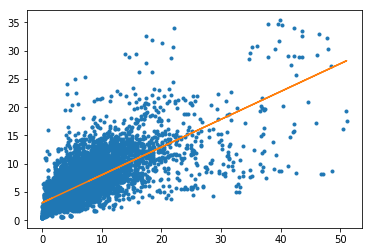

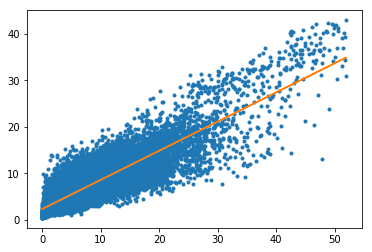

Score for Test set:  0.516068970793897
Score for Train set:  0.7152410758240403


In [36]:
print("Max features reduced to square root and depth reduced to 10")
rffunction(DF_for_RF = DFforRF1_POPDIV, n_est_number = 100, rstate = 42, mdepth = 10, max_feat_str = "sqrt")

### Random Forest #3
1. I realized that there are several TOTAL features, which simply sum other features (see below). These make interpreting the results of the ranodm forest tought. It would be much better to remove these features. 
2. Below, I convince myself that total columns really are summing other columns and I remove these columns or convert to new variable (Other) in the case of Programs.

3. CONCLUSION: YES, Results are much more interpretable, this is the model to use. 
4. I did not try to reduce overfitting for this model, given lack of success above. This is something to go back to and consider doing. 

5. NOTE: The end results that I show in my demo are abit different only because of the randomness associated with running a random forest (i.e. features picked for each tree) AND the fact that these will have variability every time because I am talking a random 20% of libraries for the test set.

In [37]:
#1. Total programs is KIDPRO + YAPRO + other programs. 
#Convert total programs to other programs so it doesn't include KIDPRO and YAPRO.
print(DFforRF1_POPDIV[['TOTPRO', 'KIDPRO', 'YAPRO']].loc[1:4])

#2. TOTOPEXP (Total operating expenditures)  = sum of STAFFEXP, TOTEXPCO, and OTHOPEXP
#DELETE TOTOPEXP from RF!!
print(DFforRF1_POPDIV[['TOTOPEXP-TOTOPEXP1', 'STAFFEXP-TOTEXP', 'TOTEXPCO-TOTEXPCOL','OTHOPEXP']].loc[2:5])

#3. TOTEXPCO (Total collection expenditure) = sum of PRMATEXP, ELMATEXP, and OTHMATEX
#DELETE TOTEXPCO for now!!
print(DFforRF1_POPDIV[['TOTEXPCO-TOTEXPCOL', 'PRMATEXP', 'ELMATEXP','OTHMATEX']].loc[2:5])

#4. STAFFEXP (Total staff expenditures) =  sum of SALARIES and BENEFIT
#DELETE STAFFEXP for now. 
print(DFforRF1_POPDIV[['STAFFEXP-TOTEXP', 'BENEFIT', 'SALARIES']].loc[2:5])

#35. Total paid FTE employees (i.e., sum of LIBRARIA and OTHPAID)
#DELETE TOTPEMP-TOTSTAFF
print(DFforRF1_POPDIV[['TOTPEMP-TOTSTAFF', 'LIBRARIAN-LIBRARIA', 'OTHPAID']].loc[2:5])

     TOTPRO    KIDPRO     YAPRO
1  0.003290  0.003049  0.000103
2  0.036364  0.036364  0.000000
3  0.030674  0.030157  0.000345
4  0.027182  0.019181  0.000308
   TOTOPEXP-TOTOPEXP1  STAFFEXP-TOTEXP  TOTEXPCO-TOTEXPCOL     OTHOPEXP
2           49.134545      4532.219406           13.232727  1451.585619
3           54.959848        47.744960            5.874031     1.340858
4           26.511437        19.786337            2.199302     4.525798
5           94.520000      6231.801684           32.165000  1995.930226
   TOTEXPCO-TOTEXPCOL   PRMATEXP  ELMATEXP  OTHMATEX
2           13.232727  10.323636  0.000000  2.909091
3            5.874031   4.708944  0.296054  0.869033
4            2.199302   2.199302  0.000000  0.000000
5           32.165000  30.190000  0.000000  1.975000
   STAFFEXP-TOTEXP      BENEFIT     SALARIES
2      4532.219406  1176.630692  3355.281807
3        47.744960    16.191625    31.553334
4        19.786337     6.894861    12.891476
5      6231.801684  1617.867202  46

In [38]:
#Calculate and add OTHPRO (Other programs).
#Delete 'TOTOPEXP-TOTOPEXP1', 'TOTEXPCO-TOTEXPCOL', 'STAFFEXP-TOTEXP', 'TOTPRO', 'TOTPEMP-TOTSTAFF'
DFforRF1_POPDIV_DELETE3COLS = DFforRF1_POPDIV.drop(columns = ['TOTOPEXP-TOTOPEXP1', 'TOTEXPCO-TOTEXPCOL', 'STAFFEXP-TOTEXP', 'TOTPEMP-TOTSTAFF'])
DFforRF1_POPDIV_DELETE3COLS_ADDPRO = copy.deepcopy(DFforRF1_POPDIV_DELETE3COLS)
DFforRF1_POPDIV_DELETE3COLS_ADDPRO['OTHPRO'] = DFforRF1_POPDIV_DELETE3COLS_ADDPRO['TOTPRO'] - (DFforRF1_POPDIV_DELETE3COLS_ADDPRO['YAPRO'] + DFforRF1_POPDIV_DELETE3COLS_ADDPRO['KIDPRO'])
DFforRF1_POPDIV_DELETE3COLS_ADDPRO = DFforRF1_POPDIV_DELETE3COLS_ADDPRO.drop(columns = ['TOTPRO'])

In [39]:
print(DFforRF1_POPDIV.shape)
print(DFforRF1_POPDIV_DELETE3COLS.shape)
print(DFforRF1_POPDIV_DELETE3COLS_ADDPRO.shape)

(61237, 29)
(61237, 25)
(61237, 25)


In [43]:
###GET random set of libraries to remove
DFforRF1_POPDIV_DELETE3COLS_ADDPRO = DFforRF1_POPDIV_DELETE3COLS_ADDPRO.reset_index(drop=True)
LocforRF1 = LocforRF1.reset_index(drop=True)

UniqueFSCS = set(LocforRF1.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = LocforRF1[LocforRF1.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

9410
12233


                    importance
PRMATEXP              0.334239
OTHPAID               0.077090
DUPLI-HRS_OPEN        0.057269
LIBRARIAN-LIBRARIA    0.055354
KIDPRO                0.049526
LOANFM                0.044754
OTHPRO                0.044458
VIDEO                 0.043213
BKVOL                 0.039406
SALARIES              0.032243
AUDIO                 0.031349
OTHMATEX              0.026828
CENTLIB               0.023656
LOANTO                0.022797
OTHOPEXP              0.021666
YAPRO                 0.021032
BENEFIT               0.018638
ELMATEXP              0.016437
MASTER                0.014213
EBOOK                 0.012720
CAPITAL               0.008816
BRANLIB               0.003297
BKMOB                 0.000998


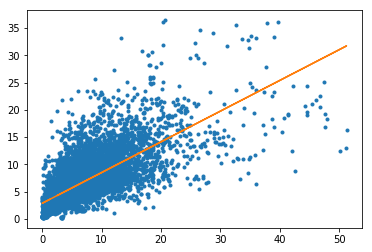

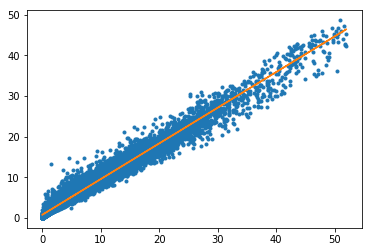

Score for Test set:  0.5077215327623896
Score for Train set:  0.9616578422895882


In [50]:
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

X = DFforRF1_POPDIV_DELETE3COLS_ADDPRO.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = DFforRF1_POPDIV_DELETE3COLS_ADDPRO['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

### Plot model results (of Random Forest #3) in multiple ways. 
1. Usage vs. Predicted usage.  
2. Usage vs. Predicted usage with point density overlaid. 
3. Feature importance.
4. Validation: error percents
5. Validation: error in absolute values

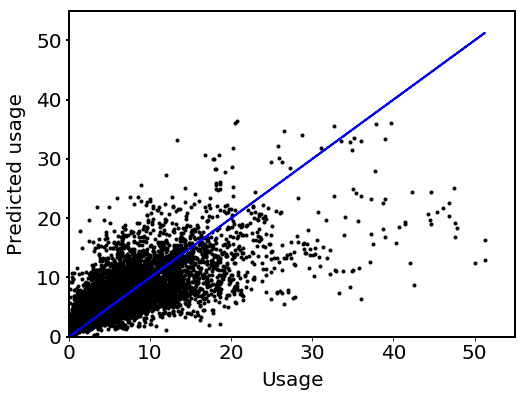

In [51]:
#Usage vs. Predicted usage.
os.chdir('/Users/Olga/Documents/INSIGHT2019/Demos/Figures/')
plt.rcParams.update({'font.size': 20})
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.figure(figsize=(8,6))
# Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
plt.plot(x, y, '.', color = "black")
plt.plot(x, x, '-', color = "blue", lw = 2)
plt.xlabel("Usage",  labelpad = 8)
plt.ylabel("Predicted usage",  labelpad = 10)
plt.ylim(0, 55)
plt.xlim(0, 55)
plt.show()
#plt.savefig('RFUsageVSPred.png', dpi=300)

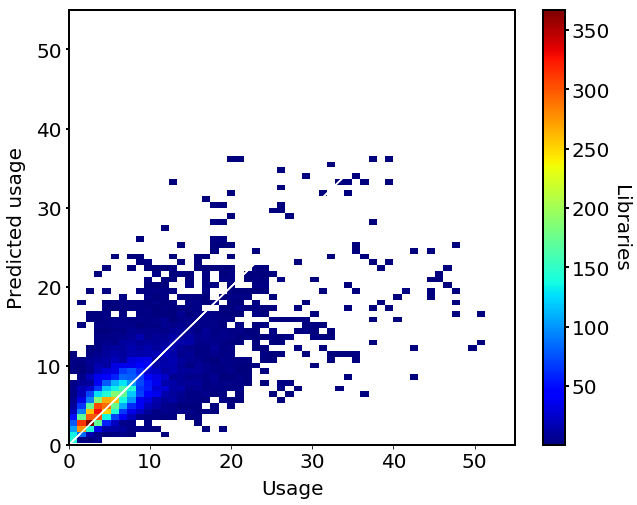

In [53]:
#Usage vs. Predicted usage with point density overlaid. 
my_cmap = plt.cm.jet
my_cmap.set_under('w',0.5)

plt.rcParams.update({'font.size': 20})
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.figure(figsize=(10,8))
plt.hist2d(x, y, bins = 50, cmap=my_cmap, vmin = 0.5)
cb = plt.colorbar()
cb.set_label('Libraries', rotation=270, labelpad = 20)
plt.xlabel("Usage",  labelpad = 8)
plt.ylabel("Predicted usage",  labelpad = 10)
plt.yticks((0, 10, 20, 30, 40, 50), [0, 10, 20, 30, 40, 50])
plt.plot(x, x, color = "white")
plt.ylim(0, 55)
plt.xlim(0, 55)

plt.show()

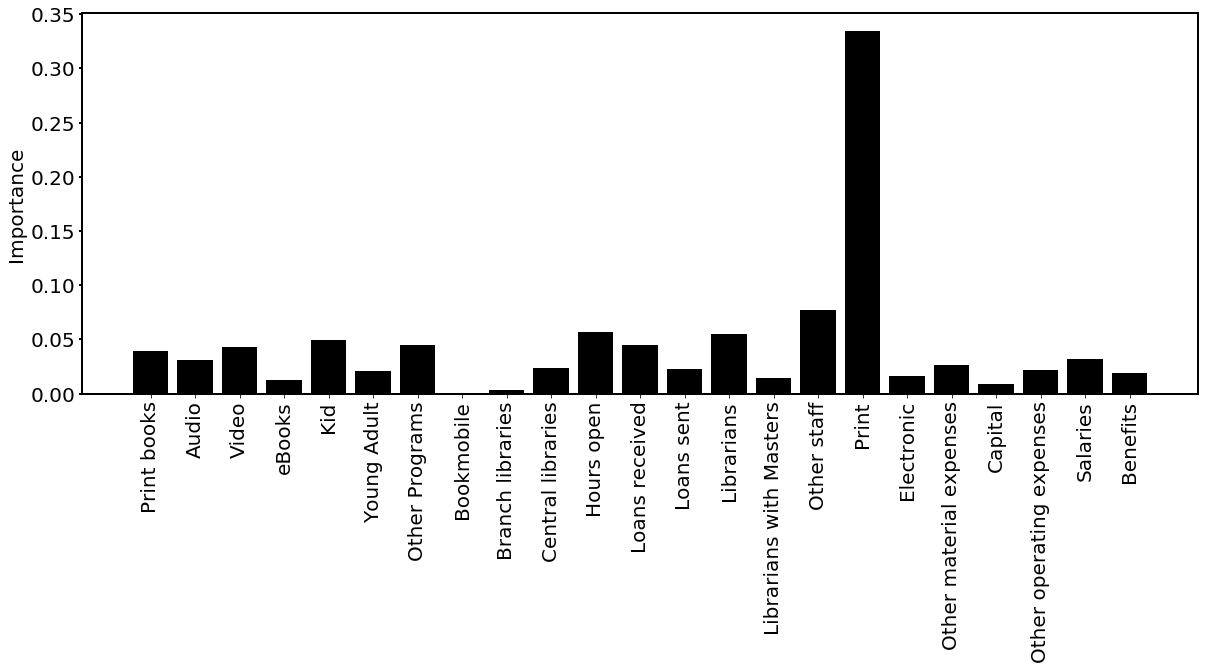

In [58]:
#Plot feature importance
feature_importances.index.values

feature_importances_reordered = feature_importances.reindex(['BKVOL', 'AUDIO','VIDEO',  'EBOOK', 'KIDPRO', 'YAPRO', 'OTHPRO', 'BKMOB', 'BRANLIB', 'CENTLIB', 'DUPLI-HRS_OPEN', 
                                                            'LOANFM', 'LOANTO', 'LIBRARIAN-LIBRARIA', 'MASTER', 'OTHPAID','PRMATEXP', 'ELMATEXP', 'OTHMATEX',  'CAPITAL', 'OTHOPEXP', 'SALARIES', 'BENEFIT'])

feat_imp_writtenout = ["Print books", "Audio", "Video", "eBooks", "Kid", "Young Adult", "Other Programs",
                      "Bookmobile", "Branch libraries", "Central libraries", "Hours open", "Loans received",
                      "Loans sent", "Librarians", "Librarians with Masters", "Other staff",
                      "Print", "Electronic", "Other material expenses", "Capital", "Other operating expenses", "Salaries", "Benefits"]

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,7))

plt.bar(feat_imp_writtenout, list(feature_importances_reordered['importance']), color = "black")
plt.xticks(rotation=90)
plt.ylabel("Importance")
plt.show()

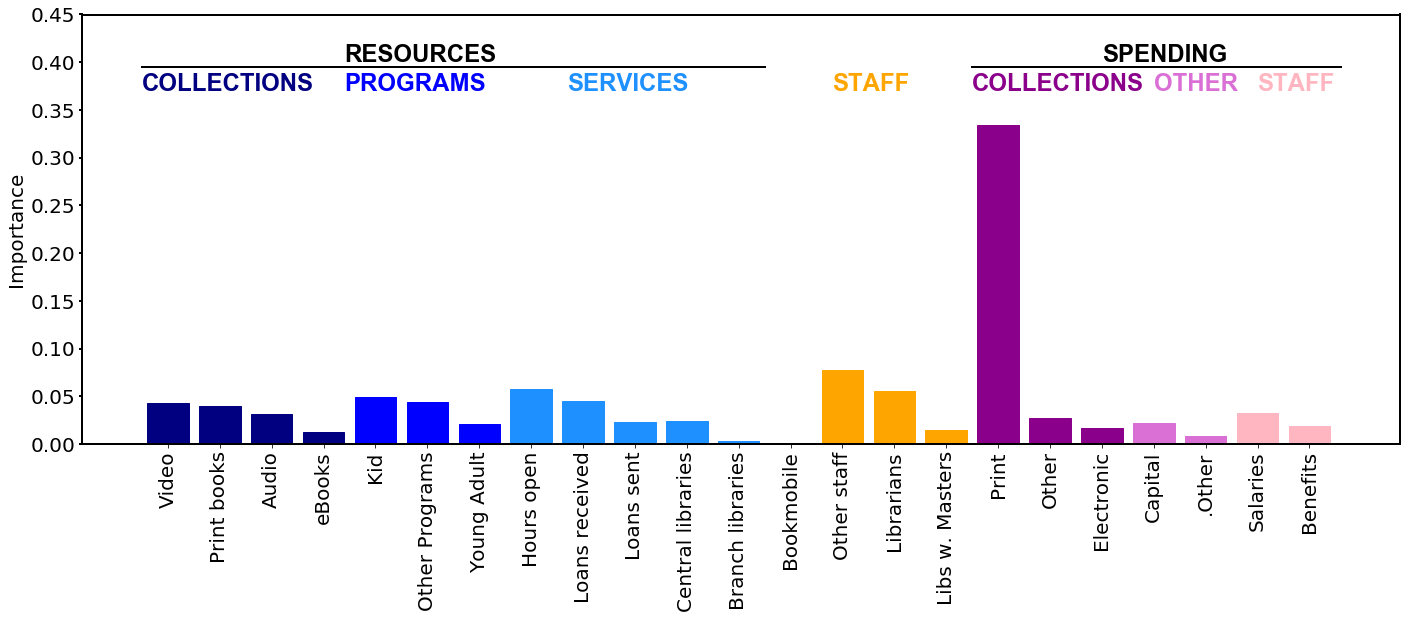

In [63]:
#Plot feature importance
feature_importances_reordered_again = feature_importances.reindex(['VIDEO', 'BKVOL', 'AUDIO',  'EBOOK', 'KIDPRO', 'OTHPRO','YAPRO',  'DUPLI-HRS_OPEN', 'LOANFM', 'LOANTO', 'CENTLIB', 'BRANLIB', 'BKMOB', 'OTHPAID',   
                                                             'LIBRARIAN-LIBRARIA', 'MASTER', 'PRMATEXP', 'OTHMATEX', 'ELMATEXP',   'OTHOPEXP', 'CAPITAL',  'SALARIES', 'BENEFIT'])
feat_imp_writtenout_reordered_again = ["Video", "Print books", "Audio", "eBooks", "Kid", "Other Programs", "Young Adult" ,"Hours open", "Loans received",
                      "Loans sent", "Central libraries", "Branch libraries", "Bookmobile", "Other staff",
                        "Librarians", "Libs w. Masters", 
                      "Print",  "Other", "Electronic",  "Capital", ".Other", "Salaries", "Benefits"]
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,9))

barplt = plt.bar(feat_imp_writtenout_reordered_again, list(feature_importances_reordered_again['importance']), color = "black")
for i in range(0, 4):  
    barplt[i].set_color('navy')
for i in range(4, 7):  
    barplt[i].set_color('blue')
for i in range(7, 13):  
    barplt[i].set_color('dodgerblue')
for i in range(13, 16):  
    barplt[i].set_color('orange')
for i in range(16, 19):  
    barplt[i].set_color('darkmagenta')
for i in range(19, 21):
    barplt[i].set_color('orchid')
for i in range(21, 23):
    barplt[i].set_color('lightpink')
plt.xticks(rotation=90)
plt.ylim(0, .45)
plt.ylabel("Importance")
plt.text(3.4, 0.4, "RESOURCES", color = 'black', fontsize = 24, fontname = "arial", fontweight = "semibold")
plt.text(18, 0.4, "SPENDING", color = 'black', fontsize = 24, fontname = "arial", fontweight = "semibold")

plt.text(-.5, 0.37, "COLLECTIONS", color = 'navy', fontsize = 24, fontname = "arial", fontweight = "semibold")
plt.text(3.4, 0.37, "PROGRAMS", color = 'blue', fontsize = 24, fontname = "arial", fontweight = "semibold")
plt.text(7.7, 0.37, "SERVICES", color = 'dodgerblue', fontsize = 24, fontname = "arial", fontweight = "semibold")
plt.text(12.8, 0.37, "STAFF", color = 'orange', fontsize = 24, fontname = "arial", fontweight = "semibold")
plt.text(15.5, 0.37, "COLLECTIONS", color = 'darkmagenta', fontsize = 24, fontname = "arial", fontweight = "semibold")
plt.text(19, 0.37, "OTHER", color = 'orchid', fontsize = 24, fontname = "arial", fontweight = "semibold")
plt.text(21, 0.37, "STAFF", color = 'lightpink', fontsize = 24, fontname = "arial", fontweight = "semibold")

plt.plot([-.5, 11.5], [.395, .395], color='k', linestyle='-', linewidth=2)
plt.plot([15.5, 22.6], [.395, .395], color='k', linestyle='-', linewidth=2)
plt.tight_layout()
os.chdir('/Users/Olga/Documents/INSIGHT2019/Demos/Figures/')
#plt.savefig('FeatImp.png', dpi=300, transparent=True)


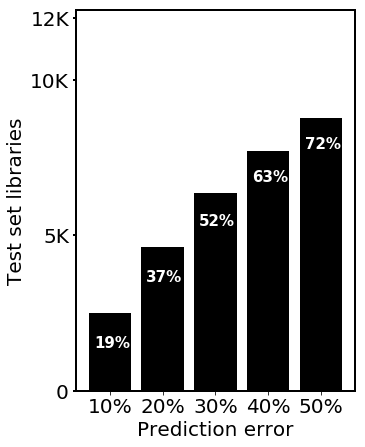

In [67]:
#Validation: error percents
df_TEST['error_pct'] = 100*df_TEST['errors']/df_TEST['Usage_val']

df_TEST['error_pct'] = 100*df_TEST['errors']/df_TEST['Usage_val']

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(5,7))

ranges_list = [len(df_TEST[df_TEST['error_pct'] < 10].index), len(df_TEST[df_TEST['error_pct'] < 20].index), len(df_TEST[df_TEST['error_pct'] < 30].index), len(df_TEST[df_TEST['error_pct'] < 40].index), len(df_TEST[df_TEST['error_pct'] < 50].index)]
percents = ['10%', '20%', '30%', '40%', '50%']
plt.bar(percents, ranges_list, color = "black")
plt.ylabel("Test set libraries")
plt.ylim(0, 12235)
plt.xlabel("Prediction error")
plt.yticks((0, 5000, 10000, 12000), ('0', '5K', '10K', '12K'))
plt.text(-.3, 2375-1000, "19%", fontsize=15, color = "white", weight = 'bold')
plt.text(0.69, 4503-1000, "37%", fontsize=15, color = "white", weight = 'bold')
plt.text(1.69, 6312-1000, "52%", fontsize=15, color = "white", weight = 'bold')
plt.text(2.69, 7731-1000, "63%", fontsize=15,color = "white", weight = 'bold')
plt.text(3.69, 8794-1000, "72%", fontsize=15,color = "white", weight = 'bold')
plt.show()

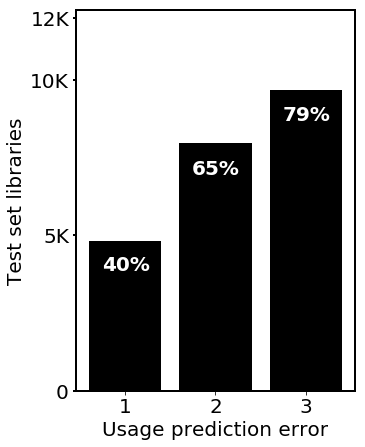

In [68]:
#Validation: error absolute value.
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(5,7))

ranges_list = [len(df_TEST[df_TEST.errors < 1].index), len(df_TEST[df_TEST.errors < 2].index), len(df_TEST[df_TEST.errors < 3].index)]
use_error = ['1', '2', '3']
plt.bar(use_error, ranges_list, color = "black")
plt.ylabel("Test set libraries")
plt.ylim(0, 12235)
plt.xlabel("Usage prediction error")
plt.yticks((0, 5000, 10000, 12000), ('0', '5K', '10K', '12K'))
plt.text(-.25, 4870-1000, "40%", fontsize=20, color = "white", weight = 'bold')
plt.text(0.74, 7953-1000, "65%", fontsize=20, color = "white", weight = 'bold')
plt.text(1.74, 9687-1000, "79%", fontsize=20, color = "white", weight = 'bold')
plt.show()

### This was the code I used to save dataframe to be used in front-end application. I saved this dataframe in a previous notebook, so I will comment it out here so as not to over-ride it here. 

In [775]:
#Save dataframes of trials, 2016 data ONLY and include POPU-POPU_LSA and LIBNAME (no usage)
#THIS WAS THE CODE I USED 
# #FEATURES_wLIBNAME = copy.deepcopy(DFforRF1_POPDIV_DELETE3COLS_ADDPRO.drop(columns = ['Usage']))
# #FEATURES_wLIBNAME['LIBNAME'] = LocforRF1['LIBNAME']
# FEATURES_wLIBNAME['STABR'] = LocforRF1['STABR']
# FEATURES_wLIBNAME['FSCSKEY'] = LocforRF1['FSCSKEY']
# print(FEATURES_wLIBNAME.shape)

# #Change order of columns so Popu-LSA is last (just prior to LIBNAME).
# list(FEATURES_wLIBNAME.columns)

# FEATURES_wLIBNAME_reorder = FEATURES_wLIBNAME[['BENEFIT','BKMOB','BKVOL','BRANLIB','CAPITAL','CENTLIB','EBOOK','ELMATEXP','DUPLI-HRS_OPEN','KIDPRO','LIBRARIAN-LIBRARIA',
#  'LOANFM','LOANTO','MASTER','OTHMATEX','OTHOPEXP','OTHPAID','PRMATEXP','SALARIES',
#  'YAPRO','AUDIO','VIDEO','OTHPRO','POPU-POPU_LSA','LIBNAME','STABR','FSCSKEY']]

# #Add state to LIBNAME
# FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE = copy.deepcopy(FEATURES_wLIBNAME_reorder)
# FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE['LIBNAMESTATE'] = FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE['LIBNAME'].map(str) + str(" (") + FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE["STABR"] + str(")") 
# FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE = FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE.drop(columns = ['LIBNAME', 'STABR'])

# #Get 2016 data only
# FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE  = FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE.reset_index(drop = True)
# idx = FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE[FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE.FSCSKEY == "AK0001"].index
# FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE_2016ONLY = FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE.iloc[list(idx)[5]:, :]
# FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE_2016ONLY = FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE_2016ONLY.drop(columns = ["FSCSKEY"])

# #drop rows without Library names
# FinalDFforFLASK = copy.deepcopy(FEATURES_wLIBNAME_reorder_LIBNAMEwSTATE_2016ONLY)
# FinalDFforFLASK = FinalDFforFLASK.reset_index(drop = True) 
# ind = np.where(FinalDFforFLASK['LIBNAMESTATE'].isnull())
# FinalDFforFLASK=FinalDFforFLASK.drop(FinalDFforFLASK.index[ind])

#convert the few negative othpro to 0.
#idx = FinalDFforFLASK[FinalDFforFLASK.OTHPRO < 0].index
#FinalDFforFLASK_no0 = copy.deepcopy(FinalDFforFLASK)

# FinalDFforFLASK_no0.to_csv(path_or_buf = "/Users/Olga/Documents/INSIGHT2019/Feb4InterimFiles/noon/FinalDFforFLASK.csv", index = False)



(61241, 27)


### Linear regression performs worse than random forest. 
1. In a previous notebook, prior to trying the random forest, I had tried a linear regression model. 
2. The random forest outperformed the linear regression. 
3. This makes some sense - some features are correlated (see below) and a random forest handles correlated features better than a linear regression. A linear regression assumes no correlation between features. Also, random forest can model non-linear relationships between features.
4. Below, I run the linear regression model again for completeness.

In [69]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

X = DFforRF1_POPDIV_DELETE3COLS_ADDPRO.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = DFforRF1_POPDIV_DELETE3COLS_ADDPRO['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

normalized_X = preprocessing.normalize(X_train)
normalize_X_test = preprocessing.normalize(X_test)

model = LinearRegression()
model.fit(normalized_X, y_train)
print(model.score(normalize_X_test, y_test))
print(model.score(normalized_X, y_train))

Coefficients = list(model.coef_)

0.2982069140848982
0.31543981325421167


In [71]:
predictions = model.predict(normalize_X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST_LR = pd.DataFrame()
df_TEST_LR['Usage_val'] = y_test
df_TEST_LR['Predictions'] = predictions
df_TEST_LR['errors'] = (list(errors))


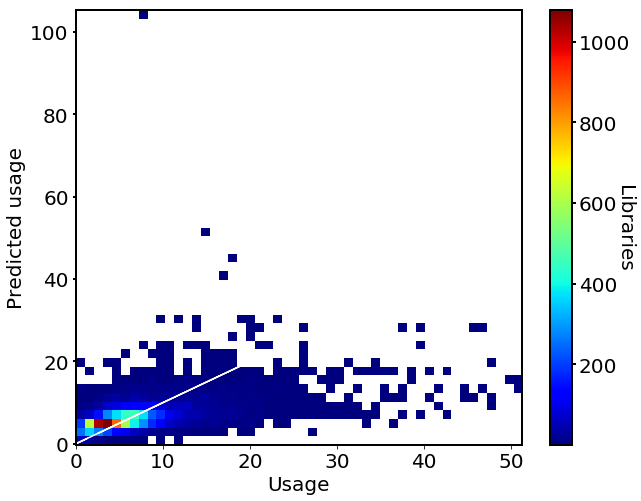

In [73]:
my_cmap = plt.cm.jet
my_cmap.set_under('w',0.5)

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,8))
plt.hist2d(x, y, bins = 50, cmap=my_cmap, vmin = 0.5)
cb = plt.colorbar()
cb.set_label('Libraries', rotation=270)
plt.xlabel("Usage")
plt.ylabel("Predicted usage")
plt.plot(x, x, color = "white")
plt.show()

### Plor Feature Correlations 

In [76]:
corr = DFforRF1_POPDIV_DELETE3COLS_ADDPRO.drop(columns = ['Usage', 'POPU-POPU_LSA']).corr()
#plt.matshow(DFforRF1_POPDIV_DELETE3COLS_ADDPRO_20ONNLY.drop(columns = ['Usage', 'POPU-POPU_LSA']).corr())

In [77]:
print(DFforRF1_POPDIV_DELETE3COLS_ADDPRO.columns)
colsforcorr = ['Benefits', 'Bookmobile', 'Book volume', 'Branch libraries', 'Capital exp.', 'Central libraries', 
 'eBooks', 'Electronic material exp.', 'Hours open', "Kid's programs", 'Librarians', 'Loans received', 
'Loans sent', 'Librarians with MAs', 'Other material expenses', 'Other operational expenses', 'Other paid staff', 'POPU-POPU_LSA',
'Print material expenses', 'Salaries', 'Young adult programs', 'Audio', 'Video', 'Usage','Other programs']
DFforcorr = copy.deepcopy(DFforRF1_POPDIV_DELETE3COLS_ADDPRO)
DFforcorr.columns = colsforcorr

corr = DFforcorr.drop(columns = ['Usage', 'POPU-POPU_LSA']).corr()

#DFforCorr = DFforRF1_POPDIV_DELETE3COLS_ADDPRO_20ONNLY[colsforcorr]

Index(['AUDIO', 'BENEFIT', 'BKMOB', 'BKVOL', 'BRANLIB', 'CAPITAL', 'CENTLIB',
       'EBOOK', 'ELMATEXP', 'DUPLI-HRS_OPEN', 'KIDPRO', 'LIBRARIAN-LIBRARIA',
       'LOANFM', 'LOANTO', 'MASTER', 'OTHMATEX', 'OTHOPEXP', 'OTHPAID',
       'POPU-POPU_LSA', 'PRMATEXP', 'SALARIES', 'VIDEO', 'YAPRO', 'Usage',
       'OTHPRO'],
      dtype='object')


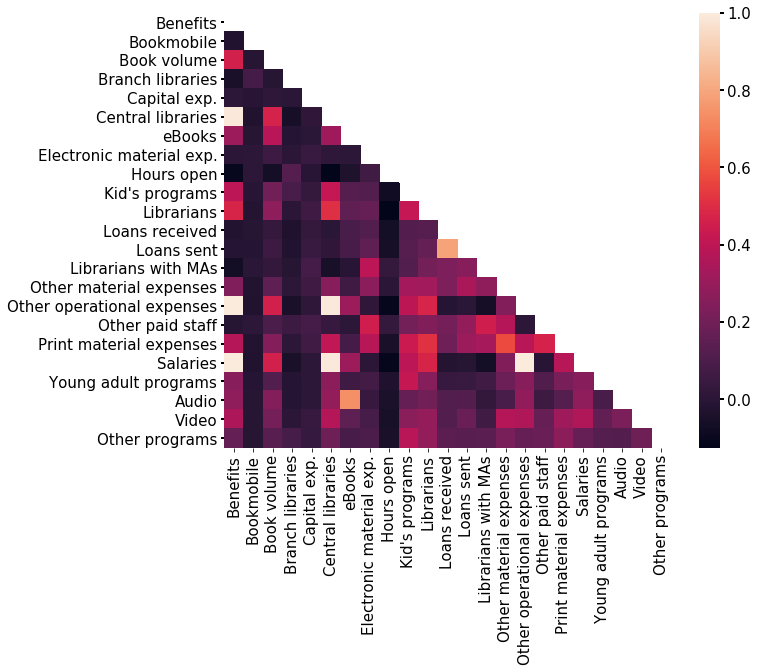

In [853]:
import seaborn as sbn

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,8))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sbn.heatmap(corr, mask=mask)